In [2]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [3]:
# get data files
#!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

#!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [87]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

print(df_ratings.info())
print(df_books.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   isbn    271379 non-null  object
 1   title   271379 non-null  object
 2   author  271377 non-null  object
dtypes: object(3)
memory usage: 6.2+ MB
None


In [ ]:

# filtering and merging the two dataframes

# users with >=200 ratings
user_counts = df_ratings['user'].value_counts()
valid_users = user_counts[user_counts >= 200].index

# books with >=100 ratings
book_counts = df_ratings['isbn'].value_counts()
valid_books = book_counts[book_counts >= 100].index

# applying both filters at the same time
df_filtered = df_ratings[df_ratings['user'].isin(valid_users) & df_ratings['isbn'].isin(valid_books)]

# merge
df_merged = df_filtered.merge(df_books, on='isbn')

# unqie book titles
df_unique = df_merged.drop_duplicates(['title', 'user'])

#print(df_unique.info)


In [ ]:

df_pivot = df_unique.pivot_table(index='title', columns='user', values='rating').fillna(0)

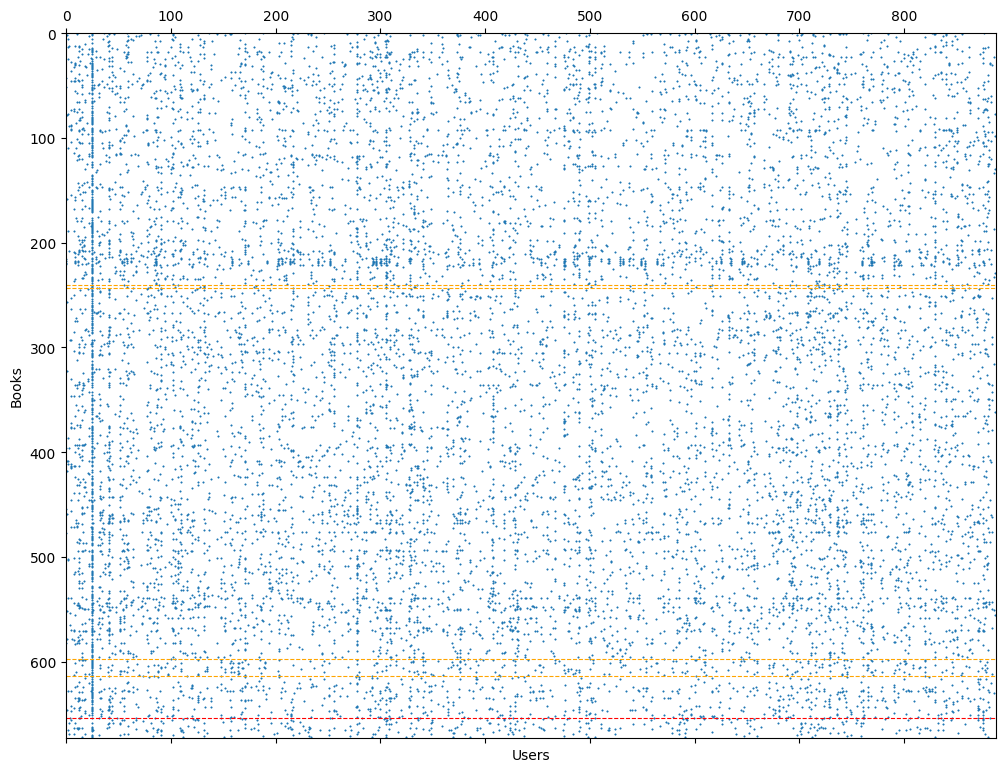

In [ ]:
# sparse matrix
sparse_matrix = csr_matrix(df_pivot.values)


book_title = "Where the Heart Is (Oprah's Book Club (Paperback))"  # change this to any book you're interested in
recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']


book_index = df_pivot.index.get_loc(book_title)
book1 = df_pivot.index.get_loc(recommended_books[0])
book2 = df_pivot.index.get_loc(recommended_books[1])
book3 = df_pivot.index.get_loc(recommended_books[2])
book4 = df_pivot.index.get_loc(recommended_books[3])

plt.figure(figsize=(12, 10))
plt.spy(sparse_matrix, markersize=0.5)

plt.axhline(y=book1, color='orange', linestyle='--', linewidth=0.8)
plt.axhline(y=book2, color='orange', linestyle='--', linewidth=0.8)
plt.axhline(y=book3, color='orange', linestyle='--', linewidth=0.8)
plt.axhline(y=book4, color='orange', linestyle='--', linewidth=0.8)
plt.axhline(y=book_index, color='red', linestyle='--', linewidth=0.8)

plt.xlabel("Users")
plt.ylabel("Books")
plt.show()

In [124]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [125]:

def get_recommends(title):
    if title not in df_pivot.index:
        print(f"'{title}' not found in dataset.")
        return [title, []]

    book_idx = df_pivot.index.get_loc(title)

    distances, indices = model_knn.kneighbors(
        df_pivot.iloc[book_idx, :].values.reshape(1, -1),
        n_neighbors=6
    )

    recs = []
    for i in range(1, len(indices[0])):
        similar_title = df_pivot.index[indices[0][i]]
        score = float(distances[0][i])
        recs.append([similar_title, score])

    recs.reverse()

    return [title, recs]

print(get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))"))




["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016210794448853], ['The Weight of Water', 0.7708583474159241], ['The Surgeon', 0.7699410915374756], ['I Know This Much Is True', 0.7677075266838074], ['The Lovely Bones: A Novel', 0.7234864234924316]]]


In [123]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

  

test_book_recommendation()

'Where the Heart Is (Oprah's Book Club (Paperback))' found at index 654.
["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016210794448853], ['The Weight of Water', 0.7708583474159241], ['The Surgeon', 0.7699410915374756], ['I Know This Much Is True', 0.7677075266838074], ['The Lovely Bones: A Novel', 0.7234864234924316]]]
'Where the Heart Is (Oprah's Book Club (Paperback))' found at index 654.
You passed the challenge! 🎉🎉🎉🎉🎉
